# Predicting the presence of heart disease using a patient’s age, maximum heart rate and ST depression
## Introduction
Given our preliminary data exploration conducted with the Cleveland Heart Disease data set (more on this below), we initially chose to use 4 variables to use when building a classifier that would be designed to predict whether or not a patient has heart disease. However, due to our limited knowledge at this time, we are not able to use the "thal" variable 
(indicating the status of the patient's thalassemia (a blood disorder)) since it is a categorical variable and can't be used in a KNN classifier. As such we will be using the following 3 *numerical* variables to build our KNN classifier:
* Maximum heart rate achieved by the patient (bpm)
* Age of the patient
* Exercise-induced ST depression (measured by ECG)
  
As found in a 16-year study of initially healthy men, "maximal exercise-induced heart rate \[is] associated with cardiovascular mortality" (Sandvik et al.). Age has also been found to impact a patient's risk of developing heart disease, as "\[h]eart disease is much more common in older age" (Nutrition Health Review 14). Lastly, ST depression can "indicate health conditions" related to the patient's heart health (Rowden & Goodwin). Therefore, we chose these variables as they were found to have an association with our response variable (diagnosis) both in previous research as well as our preliminary data analysis.

The question we are trying to answer with this predictive data analysis below is, **given the stated variables, can we predict if a patient has heart disease?**

To answer this question, we will be using the Cleveland Heart Disease data set provided by Detrano et al., which contains biological information of potential heart disease patients at the Cleveland Clinic Foundation. In the entire data set, 139 of the patients were diagnosed with heart disease while 164 were not.

## Methods
First, we load the tidyverse package to be able to perform data analysis and visualization, along with the tidymodels package which is used for classification. We also load the gridExtra package which is used for our visualisations. This data analysis requires that the tidyverse, tidymodels, **ggmosaic** and gridExtra R packages be downloaded.

Later on in the methods we use **ggmosaic**, an extension library to ggplot, to create a visualisation of our data analysis. Thus we first had to install ggmosaic locally in order to work with it. To do that, we ran the following code **in the console** (right click on cell -> new console for notebook):

1. Run `install.packages("remotes", lib = "packages")` to install the remotes package, which is used to download packages from GitHub, into a local folder called "packages" (need to create that folder first otherwise it won't write)
2. Run `remotes::install_github("haleyjeppson/ggmosaic", lib = "packages")` to install ggmosaic from its location on GitHub using remotes into the local packages folder
3. Use `library(ggmosaic, lib.loc = "packages")` to load ggmosaic from the local folder into the R notebook

**Note:** ggmosaic requires that htmltools be version 0.5.7 or later. If an older version is installed, run `install.packages("htmltools")` in the console to update it (NOT locally) to the latest version.

The kernel will need to be restarted after installing all of these packages in order for the code below to load ggmosaic.

In [1]:
library(tidyverse)
library(tidymodels)
library(gridExtra)

library(ggmosaic, lib.loc = "packages") # load ggmosaic from the local folder after all of the above steps have been completed
set.seed(54321)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

Next we read in the data from the file available on the web, first by unzipping the file and then accessing only the data set we want. Although the dataset was provided as a .data file from the original source, the file contains comma-separated values, so we use read_csv. Since the data has no column names, we will rename them all using information available at [https://archive.ics.uci.edu/dataset/45/heart+disease].

In [2]:
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
heart_temp <- tempfile()
download.file(url, heart_temp)
data <- read_csv(unzip(heart_temp, "processed.cleveland.data"), col_names = FALSE, show_col_types = FALSE) |>
    rename(age = X1, sex = X2, chest_pain = X3, resting_blood_pressure = X4,
           cholesterol = X5, fasting_blood_sugar = X6,
           resting_ecg = X7, max_heart_rate = X8, exercise_angina = X9,
           st_depression = X10, slope = X11, major_vessels = X12, thal = X13,
           diagnosis = X14)
unlink(heart_temp)

Now since we don't want to use every variable in the data set, we will select only those that we selected during preliminary data analysis: age. maximum heart rate achieved, ST depression, and diagnosis. Also, the authors of the data have indicated that all values 1-4 of the diagnosis variable mean a positive diagnosis, and only 0 indicates a negative diagnosis, so we will combine values 1-4 into 1 to simplify the data because our goal is only to determine the presence of heart disease.

In [3]:
data_selected <- data |>
    select(age, max_heart_rate, st_depression, diagnosis) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    mutate(diagnosis = fct_recode(diagnosis, "1" = "2", "1" = "3", "1" = "4"))

cat("Table 1: Preview of the heart disease data set")
head(data_selected)

Table 1: Preview of the heart disease data set

age,max_heart_rate,st_depression,diagnosis
<dbl>,<dbl>,<dbl>,<fct>
63,150,2.3,0
67,108,1.5,1
67,129,2.6,1
37,187,3.5,0
41,172,1.4,0
56,178,0.8,0


The table above gives a sense of the data we are working with. Now we can split the data set into a training set, which will be used to build our classifier, and a testing set, which will be used to evaluate the classifier.

In [4]:
data_split <- data_selected |>
    mutate(diagnosis = fct_recode(diagnosis,
                                "Angiographic disease" = "1",
                                "Healthy" = "0")) |>
    initial_split(prop = 0.75, strata = diagnosis)

training_set <- training(data_split)
testing_set <- testing(data_split)

Before we begin the data analysis, a summary of the training data is presented below:

In [5]:
number_of_observations <- training_set |>
    group_by(diagnosis) |>
    summarize(count = n())

cat("Table 2: Number of patients in the data set that are healthy or have heart disease")
number_of_observations

mean_values <- training_set |>
    group_by(diagnosis) |>
    summarize(mean_age = mean(age), mean_max_maximum_heart_rate = mean(max_heart_rate), mean_st_depression = mean(st_depression))

cat("\n\nTable 3: Mean values of predictor variables for healthy vs. diagnosed patients")
mean_values

Table 2: Number of patients in the data set that are healthy or have heart disease

diagnosis,count
<fct>,<int>
Healthy,123
Angiographic disease,104




Table 3: Mean values of predictor variables for healthy vs. diagnosed patients

diagnosis,mean_age,mean_max_maximum_heart_rate,mean_st_depression
<fct>,<dbl>,<dbl>,<dbl>
Healthy,52.20325,158.7317,0.5609756
Angiographic disease,57.00000,140.3846,1.5730769


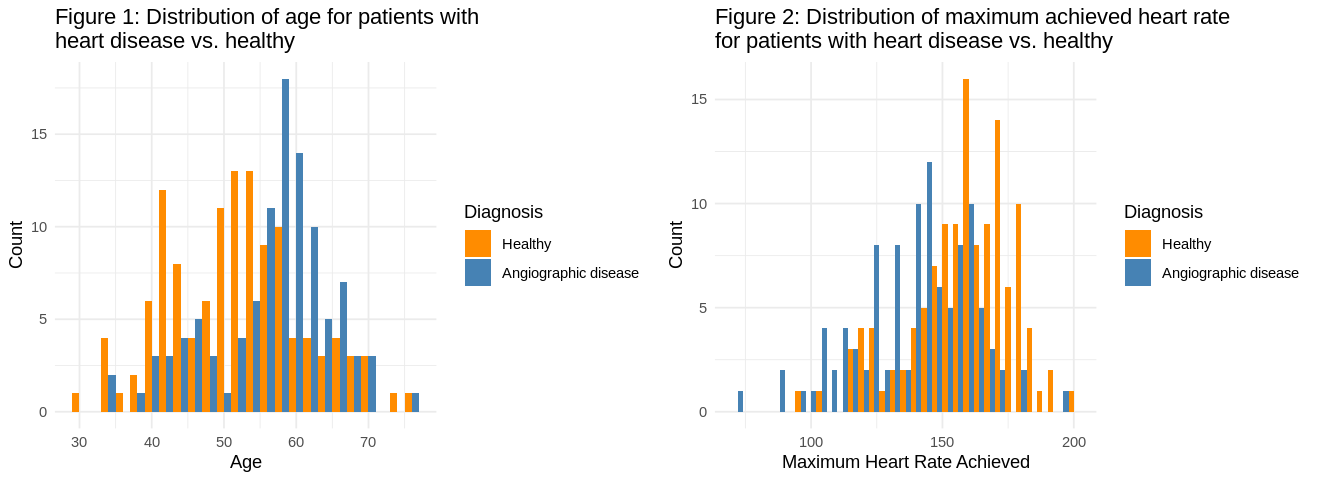

In [6]:
graph_age <- training_set |>
    ggplot(aes(x = age, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 2) +
    labs(x = "Age", y = "Count", fill = "Diagnosis") +
    ggtitle("Figure 1: Distribution of age for patients with\nheart disease vs. healthy") +
    theme(text = element_text(size = 10)) +
    theme_minimal() +
    scale_fill_manual(values = c("darkorange", "steelblue"))

graph_heart_rate <- training_set |>
    ggplot(aes(x = max_heart_rate, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 4) +
    labs(x = "Maximum Heart Rate Achieved", y = "Count", fill = "Diagnosis") +
    ggtitle("Figure 2: Distribution of maximum achieved heart rate\nfor patients with heart disease vs. healthy") +
    theme(text = element_text(size = 10)) +
    theme_minimal() +
    scale_fill_manual(values = c("darkorange", "steelblue"))

options(repr.plot.width = 11, repr.plot.height = 4)
grid.arrange(graph_age, graph_heart_rate, ncol = 2)

Now we will use cross-validation with 5 folds to determine the best K value to use for our K-nearest-neighbours classifier. We chose a range of K values from 5 to 20, since the data set only has 303 observations, and the training set is even smaller. We also create a recipe for pre-processing the data which involves standardized the data by scaling it (so that all variables have a standard deviation of 1) and centering it (so that all variables have a mean of 0). This standardization makes sure that all variables are traeated equally when the K nearest neighbors are found using distance, as they will now all be on the same scale, no 1 variable will have a greater influence than another.

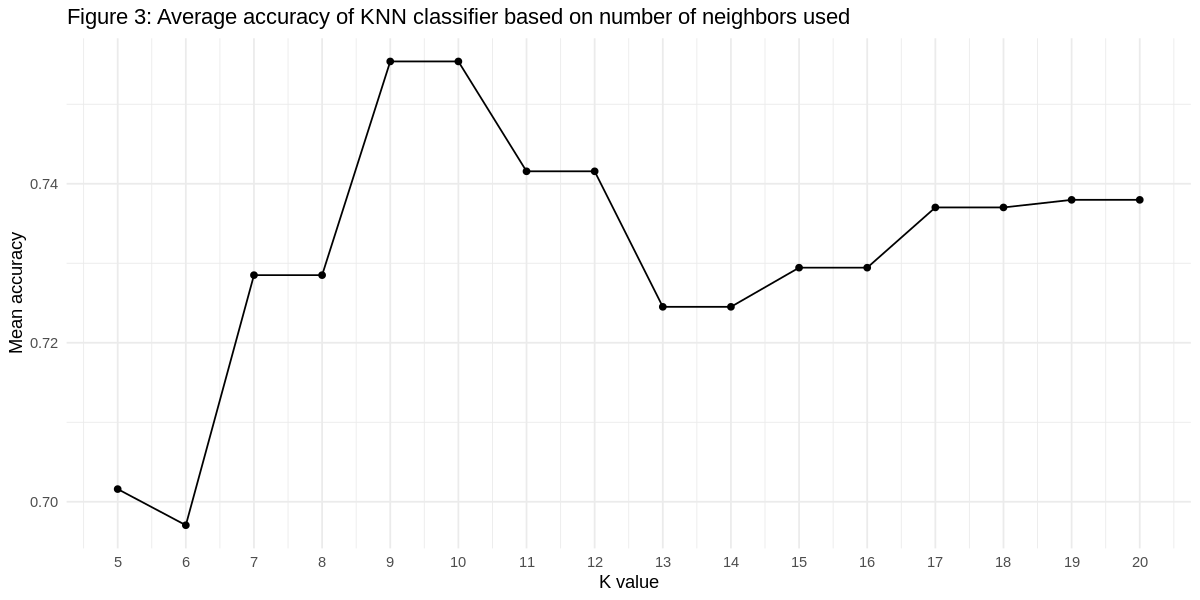

In [7]:
knn_recipe <- recipe(diagnosis ~ ., data = training_set) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = 5:20)

vfold <- vfold_cv(training_set, v = 10, strata = diagnosis)

knn_fit_tuning <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec_tune) |>
    tune_grid(resamples = vfold, grid = k_vals)

tuning_metrics <- knn_fit_tuning |>
    collect_metrics()

tuning_accuracies <- filter(tuning_metrics, .metric == "accuracy")

cross_val_plot <- tuning_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() +
    labs(x = "K value", y = "Mean accuracy") +
    ggtitle("Figure 3: Average accuracy of KNN classifier based on number of neighbors used") +
    theme(text = element_text(size = 15)) +
    theme_minimal() +
    scale_x_continuous(breaks = 5:30)

options(repr.plot.height = 5, repr.plot.width = 10)
cross_val_plot

From the above graph, we choose K to be 10 for the rest of our classifier. We chose 10 instead of 9 even though they have the same accuracy, since around a K of 10 (i.e. K = 9 and K = 11) the accuracies are higher than around K = 9 (i.e. there is a sudden drop off in accuracy when K = 8), so choosing a K where the K +/- 1 also results in similar accuracies provides some room for error that may be caused by variations.

Below we build the model and fit it to our data using our selected K value of 10.

In [8]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = training_set)

Now we will evaluate our classifier using the testing set from the original data. To do this we first calculate the accuracy using the `metrics` function. The accuracy of a classifier represents the fraction of predictions for which the classifier makes the correct prediction, in other words,
$$\text{accuracy} = \text{number of correct predictions } / \text{ total predictions}.$$

Since we are particularly interested in classifying and identifying patients with heart disease, we set this as our "important"/"positive" class, allowing us to calculate precision and recall. Precision refers to how many of the positive predictions our classifier made were actually positive. Recall refers to how many of the positive cases in the testing set our classifier actually labelled as positive.

Precision is calculated as # of true positives / all positive predictions (i.e. true positives + false positives).

Recall is calculated as # of true positives / # of positive test data points (i.e. true positives + false negatives).

Note that in order be able to set the "positive" class when calculting precision and recall using the `event_level` parameter, we first need to determine the order in which the factor levels "Healthy" and "Angiographic disease" occur.

In [9]:
predictions <- predict(knn_fit, testing_set) |>
    bind_cols(testing_set)

accuracy <- predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")

cat("Order of diagnoses in the data set:")
predictions |> pull(diagnosis) |> levels()

precision <- predictions |>
  precision(truth = diagnosis, estimate = .pred_class, event_level = "second")

recall <- predictions |>
  recall(truth = diagnosis, estimate = .pred_class, event_level = "second")

# combine accuracy, precision and recall into 1 table
metrics <- bind_rows(precision, recall, accuracy) |>
    mutate(Metric = .metric, "Value (%)" = .estimate * 100) |>
    select(Metric, "Value (%)")

cat("\n\nTable 4: Metrics for KNN classifier built with K = 10")
metrics

Order of diagnoses in the data set:

[1] "Healthy"              "Angiographic disease"



Table 4: Metrics for KNN classifier built with K = 10

Metric,Value (%)
<chr>,<dbl>
precision,60.60606
recall,57.14286
accuracy,63.15789


We also calculate the confusion matrix, which is a convenient way of analysing the types of predictions our classifier makes. This is because by labelling one class as "positive" (in this case, a diagnosis of heart disease), we can now count the number of:
* True positives (correctly diagnosed with heart disease)
* False positives (incorrectly diagnosed with heart disease)
* True negatives (correctly diagnosed as healthy)
* False negatives (incorrecly labelled as healthy)

that our classifier makes. This is useful in evaluating our classifier and understanding what kinds of mistakes it is making.

In [10]:
conf_mat <- predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)

cat("Table 5: Confusion matrix for KNN classifier with K = 10")
conf_mat

Table 5: Confusion matrix for KNN classifier with K = 10

                      Truth
Prediction             Healthy Angiographic disease
  Healthy                   28                   15
  Angiographic disease      13                   20

This is a matrix, so to better work with the data we transform it to a table and label it to be able to see exactly how our classifier is diagnosing individuals:

In [11]:
conf_mat_tbl <- tidy(conf_mat)

conf_mat_tbl[1, "name"] <- "True Negatives"
conf_mat_tbl[2, "name"] <- "False Positives"
conf_mat_tbl[3, "name"] <- "False Negatives"
conf_mat_tbl[4, "name"] <- "True  Positives"

cat("Table 6: Labelled data from confusion matrix")
conf_mat_tbl

Table 6: Labelled data from confusion matrix

name,value
<chr>,<dbl>
True Negatives,28
False Positives,13
False Negatives,15
True Positives,20


In order to visualise this data analysis, we will create a mosaic plot of the confusion matrix which will visually show the proportions of each label. To make a mosaic plot, we use the ggmosaic package installed at the beginning of this section. The way the `geom_mosaic` function works is using proportions in the data instead of numerical values (which is what we currently have, as seen in Table 6). So in order to have the table store these numbers as proportions of observations, we pull the number `n` from each row of Table 6 and use it create `n` rows of a corresponding observation in a new table, called `mosaic_data`.

In [12]:
mosaic_data <- uncount(tibble(Truth = "Healthy (-)", Predicted = "Healthy (-)"), pull(conf_mat_tbl[1, 2])) |> # true negatives
    bind_rows(uncount(tibble(Truth = "Healthy (-)", Predicted = "Diseased (+)"), pull(conf_mat_tbl[2, 2]))) |> # false positives
    bind_rows(uncount(tibble(Truth = "Diseased (+)", Predicted = "Healthy (-)"), pull(conf_mat_tbl[3, 2]))) |> # false negatives
    bind_rows(uncount(tibble(Truth = "Diseased (+)", Predicted = "Diseased (+)"), pull(conf_mat_tbl[4, 2]))) # true positives

Now we can use this data to build a mosaic plot:

Warning message:
“The `scale_name` argument of `continuous_scale()` is deprecated as of ggplot2
3.5.0.”
Warning message:
“The `trans` argument of `continuous_scale()` is deprecated as of ggplot2 3.5.0.
ℹ Please use the `transform` argument instead.”


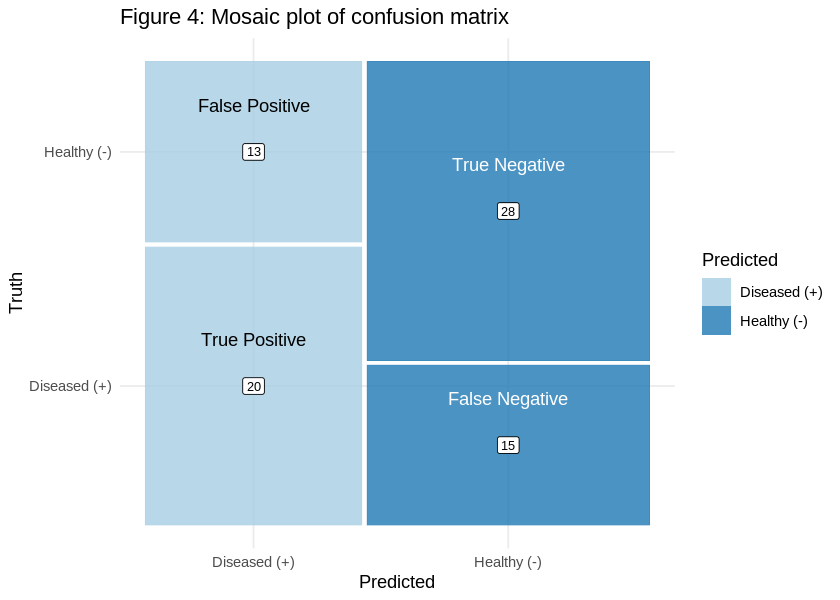

In [13]:
confusion_matrix_mosaic_plot <- ggplot(data = mosaic_data) +
    geom_mosaic(aes(x = product(Truth, Predicted), fill = Predicted)) + 
    ggtitle("Figure 4: Mosaic plot of confusion matrix") +
    theme(text = element_text(size = 18)) +
    theme_minimal() +
    geom_mosaic_text(aes(x = product(Truth, Predicted), label = after_stat(.wt)), as.label = TRUE) +
    scale_fill_brewer(palette = "Paired")

confusion_matrix_mosaic_plot <- confusion_matrix_mosaic_plot +
    geom_text(data = ggplot_build(confusion_matrix_mosaic_plot)$data[[1]] |>
                      mutate(l = c("True Positive", "False Positive", "False Negative", "True Negative"),
                            col = c("b", "b", "w", "w")), 
             aes(x = (xmin + xmax)/2, y = (ymin + ymax)/2 + 0.1, label = l, color = col)) +
    scale_color_manual(values = c("black", "white")) +
    guides(color = "none")

options(repr.plot.width = 7, repr.plot.height = 5)
confusion_matrix_mosaic_plot

From the confusion matrix we can see that 48 correct predictions were made (all true predictions) vs. 28 incorrect predictions (all false predictions). Thus while overall our classifier made more correct predictions than false ones, it still made a lot of mistakes.

# Discussion
After evaluating our k-means classification model on our testing dataset, our performance metrics showcase an approximately `63.2%` accuracy, `60.6%` precision and `57.1%` recall. According to Table 4, our accuracy metric indicates that we can correctly diagnose whether a patient has heart disease or not at a rate of 63.2%. Our precision metric indicates that our model could correctly predict the presence of heart disease at a rate of 60.6% when it is assigning positive classifications. As for our recall metric, it is indicated that our model only has a 57.1% effectiveness when identifying patients with heart disease amongst all patients who truly do have heart disease. 

Our predictive question was whether or not the aforementioned variables could indicate whether or not a patient had heart disease. In the context of diagnosing heart disease, high accuracy is important as committing false negatives would mean mislabelling patients as healthy when they truly do have heart disease, likely risking their lives. Thus, we were expecting a high accuracy for our classifier. 

Given that we had chosen relevant predictor variables (age, heart rate, depression) -- whilst avoiding high-dimensionality -- and fine-tuned our model parameters, we were expecting an accuracy of around 70-80% at least. The gap between our predicted and actual performance metrics may be attributed to the small sample size of our data. Since we have to split our data into a training and testing set, our small sample size has a high risk of bias, which may not be representative of the underlying population of heart disease patients, therefore leading to inaccurate predictions. 

Overall, we expected a balance between accuracy, precision and recall. For instance, a high recall but low precision would mean classifying many patients as having heart disease despite being healthy, this would incur unnecessary medical costs and treatments. Although we achieved a moderate balance between the three metrics, the performance of the classifier is not viable enough for it to be used in a real-world medical setting, as there is too much room for error. Specifically, we would want a high recall in a medical setting, because this corresponds to how likely we are to find any positive cases (i.e. find heart disease). This is very important in such situations since we do not want anyone to go undiagnosed. However, our recall is quite low at 57.1%, so this would not be acceptable as 40% of patients would go undiagnosed

Our model’s accuracy value is too low to be directly used as a diagnosis tool, but our findings will still have an impact on future research in this area. Given our accuracy value of 63.2%, using our predictor variables will still yield a prediction better than a random guess (which would be an accuracy value of 50%). This indicates that our choices of predictor variables are relevant and appropriate for predicting heart disease and that with further research, we'll be able to increase the accuracy. In summary, our findings will aid future research into prediction models for heart disease presence by affirming the variables of age, maximum heart rate achieved by the patient, and exercise-induced ST depression as relevant predictor variables.

What further questions could this data analysis lead to?

**What other relevant variables can/should be used in a classification model aiming to predict heart disease?**

Given our relatively low accuracy value, it may be beneficial to the accuracy value if we include new relevant variables. Exploring this question may allow for the creation of a better model.

**How much does each individual variable available in the heart disease dataset contribute to the risk of heart disease?**

Exploring this question will allow for us to know how relevant each variable is to heart disease prediction, and whether they should be included as a predictor variable.

**What other diseases can the k-nearest neighbour classification model be applied to?**

It may be possible to use the model (with different predictor variables) for other diseases, so this will allow for further research into prediction models for other diseases.


# Work Cited
Detrano, Robert, et al. “Heart Disease.” UCI Machine Learning Repository, 1988, archive.ics.uci.edu/dataset/45/heart+disease. Accessed 10 Apr. 2024. <br>

"Risk factors in middle age linked to more heart disease." Nutrition Health Review, no. 107, fall 2011, p. 14. Gale OneFile: Health and Medicine, link.gale.com/apps/doc/A302770509/HRCA?u=ubcolumbia&sid=summon&xid=661cd869. Accessed 10 Apr. 2024. <br>

Rowden, Adam, and Meredith Goodwin. “St Depression on ECG: What It Means and Causes.” Medical News Today, MediLexicon International, 9 July 2022, www.medicalnewstoday.com/articles/st-depression-on-ecg. Accessed 10 Apr. 2024. <br>

Sandvik, L et al. “Heart rate increase and maximal heart rate during exercise as predictors of cardiovascular mortality: a 16-year follow-up study of 1960 healthy men.” Coronary artery disease vol. 6,8 (1995): 667-79. doi:10.1097/00019501-199508000-00012